## Import and Prepare Data

In [1]:
# Import relevant libraries for manipulating data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import relevant libraries for Random Forest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP as zinb

In [2]:
# limit warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# read in dataset as a dataframe
df = pd.read_csv("data/BAAD_DataCompMar.2023.csv")

In [4]:
df.head()

,org,torg,year,torg_year,hbase,hbccode,hbiso,hb_iso_cc,suicide,tkill,...,fdextort,fdkidnap,fdrob,fdsmuggl,ssponsor,ucdpbd,lngroupbd,lngovtbd,socialserv,crim_degr_py
0,Abu Sayyaf Group (ASG),4,1998,4_1998,Philippines,840,PHL,608,0,0.0,...,1,1,1,1,0,55,4.025352,4.356709,0,NaN
1,Abu Sayyaf Group (ASG),4,1999,4_1999,Philippines,840,PHL,608,0,0.0,...,1,1,1,1,0,0,0.000000,4.983607,0,1.0
2,Abu Sayyaf Group (ASG),4,2000,4_2000,Philippines,840,PHL,608,1,1.0,...,1,1,1,1,0,379,5.940171,7.063904,0,0.0
3,Abu Sayyaf Group (ASG),4,2001,4_2001,Philippines,840,PHL,608,0,0.0,...,1,1,1,1,0,333,5.811141,6.218600,0,0.0
4,Abu Sayyaf Group (ASG),4,2002,4_2002,Philippines,840,PHL,608,0,0.0,...,1,1,1,1,0,249,5.521461,6.152733,0,1.0


In [5]:
# Impute missing values with mean, or drop rows
# Mean imputations by group
df["crim_degr_py"] = df['crim_degr_py'].fillna(df.groupby('hbase')['crim_degr_py'].transform('mean'))
df["lngdppc"] = df['lngdppc'].fillna(df.groupby('hbase')['lngdppc'].transform('mean'))
df["milpercap"] = df['milpercap'].fillna(df.groupby('hbase')['milpercap'].transform('mean'))

# Drop rows (for columns with < 10 missing values)
df = df[df['lnpop'].notna()]
df = df[df['cinc'].notna()]
df = df[df['vdem'].notna()]
df = df[df['tkill'].notna()]

In [6]:
df = df[['suicide', 'milpercap', 'vdem', 'lnpop', 'lngdppc', 'ngroups', 'left', 'iideol', 'ethn', 'age', 'size',
              'terrcntrl', 'lead_hierarch', 'ssponsor', 'lngroupbd', 'socialserv']].dropna()

## Process and Train Model (refined)

### Random Forest

In [7]:
# Find and encode non-numeric columns as levels
cats = df.select_dtypes(exclude=np.number).columns.tolist()
print(cats)
for feature in cats:
  df[feature]=df[feature].astype('category')

[]


In [8]:
object_cols = df.select_dtypes(exclude=np.number).columns
encoder = OrdinalEncoder()

print(object_cols)

for column in object_cols:
    df[column] = df[column].astype(str)
    df[column] = encoder.fit_transform(df[column].values.reshape(-1, 1))

print(df.head())

Index([], dtype='object')
   suicide  milpercap   vdem      lnpop   lngdppc  ngroups  left  iideol  \
0        0   1.453170  0.430  18.105203  7.352436        4     0       1   
1        0   1.437129  0.440  18.125692  7.361205        4     0       1   
2        1   1.395343  0.448  18.145810  7.383011        4     0       1   
3        0   1.373098  0.423  18.171270  7.390308        4     0       1   
4        0   1.309386  0.399  18.209392  7.405113        4     0       1   

   ethn  age  size  terrcntrl  lead_hierarch  ssponsor  lngroupbd  socialserv  
0     0    7     2          0              1         0   4.025352           0  
1     0    8     2          0              1         0   0.000000           0  
2     0    9     3          1              0         0   5.940171           0  
3     0   10     3          0              0         0   5.811141           0  
4     0   11     2          1              0         0   5.521461           0  


In [9]:
y=df[['suicide']]
X_refined=df[['milpercap', 'vdem', 'lnpop', 'lngdppc', 'ngroups', 'left', 'iideol', 'ethn', 'age', 'size',
              'terrcntrl', 'lead_hierarch', 'ssponsor', 'lngroupbd', 'socialserv']]

In [10]:
# Split into training and test sets
X_ref_train, X_ref_test, y_train, y_test = train_test_split(X_refined, y, random_state=42)

In [11]:
# Create search space for random search CV parameter optimization
rf_ref_suicide= RandomForestRegressor(random_state=42)

In [12]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt','log2']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# Random Grid Search to find best parameters
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [13]:
clf_ref= RandomizedSearchCV(rf_ref_suicide,random_grid,n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
clf_ref.fit(X_ref_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 311, 522, 733,
                                                         944, 1155, 1366, 1577,
                                                         1788, 2000]},
                   random_state=42, verbose=2)

In [14]:
# Best parameters as tested by random search CV
clf_ref.best_params_

{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 90,
 'bootstrap': True}

In [15]:
# Fitting model with best parameters
rf_ref_best = RandomForestRegressor(bootstrap= True, max_depth= 90, max_features= 'sqrt', min_samples_leaf= 1,
                           min_samples_split=2, n_estimators=2000, random_state=42)

rf_ref_best.fit(X_ref_train, y_train)

RandomForestRegressor(max_depth=90, max_features='sqrt', n_estimators=2000,
                      random_state=42)

In [16]:
# Get R-squared and RMSE
y_pred = rf_ref_best.predict(X_ref_test)
score = rf_ref_best.score(X_ref_test,y_test)
print('R_squared: ',r2_score(y_test,y_pred))
print('Root Mean Squared Error (RMSE): ', np.sqrt(mean_squared_error(y_test,y_pred)))

R_squared:  0.3903560783810156
Root Mean Squared Error (RMSE):  1.9176540710508632


In [17]:
# array of predicted values vs actual values (test set)
y_test["suicide_pred"] = y_pred
y_test.head(50)
# y_test.to_csv("test.csv")

,suicide,suicide_pred
761,0,0.2720
979,1,4.1880
1000,0,0.2775
258,0,0.0355
346,0,0.0395
499,0,0.4655
269,0,0.0030
89,0,0.0050
43,0,0.2505
1050,0,0.0000


## Random Forest with Random Grid Search (Suicide Counts)

#### R_squared:  0.39
#### Root Mean Squared Error (RMSE):  1.92

### Suicide Percent

In [18]:
# read in dataset as a dataframe
df3 = pd.read_csv("BAAD_DataCompMar.2023.csv")

In [19]:
df3 = df3[df3['psuicide'].notna()]

In [20]:
# Impute missing values with mean, or drop rows

# Mean imputations by group
df3["crim_degr_py"] = df3['crim_degr_py'].fillna(df3.groupby('hbase')['crim_degr_py'].transform('mean'))
df3["lngdppc"] = df3['lngdppc'].fillna(df3.groupby('hbase')['lngdppc'].transform('mean'))
df3["milpercap"] = df3['milpercap'].fillna(df3.groupby('hbase')['milpercap'].transform('mean'))

# Drop rows (for columns with < 10 missing values)
df3 = df3[df3['lnpop'].notna()]
df3 = df3[df3['cinc'].notna()]
df3 = df3[df3['vdem'].notna()]
df3 = df3[df3['tkill'].notna()]

In [21]:
df3 = df3[['psuicide', 'milpercap', 'vdem', 'lnpop', 'lngdppc', 'ngroups', 'left', 'iideol', 'ethn', 'age', 'size',
              'terrcntrl', 'lead_hierarch', 'ssponsor', 'lngroupbd', 'socialserv']].dropna()

In [22]:
X4=df3[['milpercap', 'vdem', 'lnpop', 'lngdppc', 'ngroups', 'left', 'iideol', 'ethn', 'age', 'size',
              'terrcntrl', 'lead_hierarch', 'ssponsor', 'lngroupbd', 'socialserv']]
y3 = df3.pop('psuicide')

In [23]:
# Split into training and test sets
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y3, random_state=42)

In [24]:
# Create search space for random search CV parameter optimization
rf4_suicide= RandomForestRegressor(random_state=42)

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt','log2']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]


random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [25]:
clf4= RandomizedSearchCV(rf4_suicide,random_grid,n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
clf4.fit(X4_train,y4_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 311, 522, 733,
                                                         944, 1155, 1366, 1577,
                                                         1788, 2000]},
                   random_state=42, verbose=2)

In [26]:
# Best parameters as tested by random search CV
clf4.best_params_

{'n_estimators': 733,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': False}

In [27]:
# Fitting model with best parameters
rf4_best = RandomForestRegressor(bootstrap=False, max_depth=30, max_features= 'sqrt', min_samples_leaf=2,
                           min_samples_split=2, n_estimators=733, random_state=42)

rf4_best.fit(X4_train, y4_train)

RandomForestRegressor(bootstrap=False, max_depth=30, max_features='sqrt',
                      min_samples_leaf=2, n_estimators=733, random_state=42)

In [28]:
# Get R-squared and RMSE
y4_pred = rf4_best.predict(X4_test)
score4 = rf4_best.score(X4_test,y4_test)
print('R_squared: ',r2_score(y4_test,y4_pred))
print('Root Mean Squared Error (RMSE): ', np.sqrt(mean_squared_error(y4_test,y4_pred)))

R_squared:  0.3051508463895304
Root Mean Squared Error (RMSE):  0.13962108150339453


In [29]:
y4_test = pd.DataFrame(y4_test)
y4_test["suicide_pred"] = y4_pred
print(y4_test.head(30))
# y4_test.to_csv("test.csv")

      psuicide  suicide_pred
1363  0.000000      0.003406
672   0.000000      0.005816
191   0.000000      0.025827
1086  0.000000      0.253284
1064  0.000000      0.034920
684   0.000000      0.005272
1067  0.000000      0.001230
437   0.000000      0.093120
686   0.000000      0.002131
1270  0.158654      0.119537
1271  0.100775      0.110953
634   0.000000      0.008905
255   0.000000      0.002602
861   0.000000      0.000051
1031  0.000000      0.005687
213   0.000000      0.051425
1254  0.000000      0.001352
1266  0.000000      0.050732
166   0.000000      0.010358
1157  0.000000      0.000391
659   0.000000      0.000415
188   0.000000      0.018616
2     0.055556      0.009640
1296  0.150289      0.145658
146   0.000000      0.268505
389   0.000000      0.002487
120   0.250000      0.493685
129   0.086957      0.211056
1091  0.000000      0.008787
37    0.000000      0.013732


## Random Forest with Random Grid Search (Suicide Percent)

#### R_squared:  0.31
#### Root Mean Squared Error (RMSE):  0.14

### Feature Importances

In [30]:
from sklearn.inspection import permutation_importance
#https://medium.com/@ali.soleymani.co/stop-using-random-forest-feature-importances-take-this-intuitive-approach-instead-4335205b933f

### Suicide Counts Feature Importances

In [35]:
r = permutation_importance(rf_ref_best, X_ref_test, y_test["suicide"],
                           n_repeats=10,
                           random_state=42)
perm = pd.DataFrame(columns=['AVG_Importance', 'STD_Importance'], index=[i for i in X_ref_train.columns])
perm['AVG_Importance'] = r.importances_mean

<Axes: >

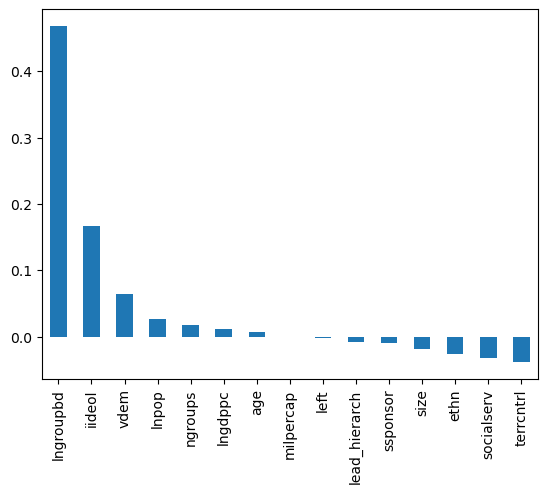

In [36]:
perm['AVG_Importance'].sort_values(ascending=False).plot.bar()

In [37]:
perm['AVG_Importance'].sort_values(ascending=False)

lngroupbd        0.467749
iideol           0.167302
vdem             0.063911
lnpop            0.027240
ngroups          0.017067
lngdppc          0.011866
age              0.007702
milpercap       -0.000812
left            -0.002259
lead_hierarch   -0.008155
ssponsor        -0.009694
size            -0.019268
ethn            -0.026787
socialserv      -0.032758
terrcntrl       -0.038481
Name: AVG_Importance, dtype: float64

### Suicide Percent Feature Importances

In [42]:
r2 = permutation_importance(rf4_best, X4_test, y4_test["psuicide"],
                           n_repeats=10,
                           random_state=42)
perm2 = pd.DataFrame(columns=['AVG_Importance', 'STD_Importance'], index=[i for i in X4_train.columns])
perm2['AVG_Importance'] = r2.importances_mean

<Axes: >

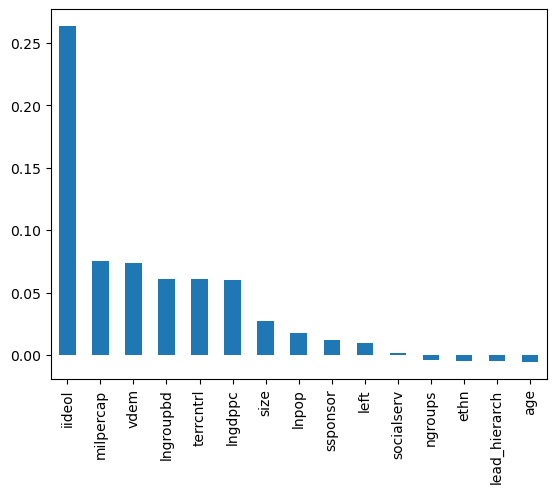

In [43]:
perm2['AVG_Importance'].sort_values(ascending=False).plot.bar()

In [44]:
perm2['AVG_Importance'].sort_values(ascending=False)

iideol           0.263526
milpercap        0.075635
vdem             0.073503
lngroupbd        0.061170
terrcntrl        0.060979
lngdppc          0.059908
size             0.027308
lnpop            0.018010
ssponsor         0.011972
left             0.009881
socialserv       0.001955
ngroups         -0.003780
ethn            -0.004509
lead_hierarch   -0.004967
age             -0.005757
Name: AVG_Importance, dtype: float64

## Neural Networks

In [45]:
# Import necessary libraries
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

### 1000 Epochs

In [50]:
# Define the neural network model
model = Sequential()
model.add(Dense(128, input_dim=15, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model to the training data
model.fit(X_ref_train, y_train, epochs=1000, batch_size=5)

# Use the model to predict sales for the test data
predictions = model.predict(X_ref_test)

Epoch 1/1000
188/188 [==============================] - 1s 1ms/step - loss: 23.5461
Epoch 2/1000
188/188 [==============================] - 0s 874us/step - loss: 21.2410
Epoch 3/1000
188/188 [==============================] - 0s 915us/step - loss: 19.5992
Epoch 4/1000
188/188 [==============================] - 0s 904us/step - loss: 17.9703
Epoch 5/1000
188/188 [==============================] - 0s 1ms/step - loss: 17.2094
Epoch 6/1000
188/188 [==============================] - 0s 984us/step - loss: 16.7485
Epoch 7/1000
188/188 [==============================] - 0s 939us/step - loss: 14.1819
Epoch 8/1000
188/188 [==============================] - 0s 946us/step - loss: 13.3075
Epoch 9/1000
188/188 [==============================] - 0s 937us/step - loss: 14.9216
Epoch 10/1000
188/188 [==============================] - 0s 902us/step - loss: 14.7169
Epoch 11/1000
188/188 [==============================] - 0s 1ms/step - loss: 12.0401
Epoch 12/1000
188/188 [==============================] - 0

In [66]:
# Evaluate the model's performance
print('R_squared: ',r2_score(y_test['suicide'],predictions))
mse = mean_squared_error(y_test['suicide'], predictions)
print("Root Mean Squared Error:", np.sqrt(mse))

R_squared:  0.04607072427228398
Root Mean Squared Error: 2.398778962528707


In [67]:
y_test_nn = y_test
y_test_nn["suicide_pred"] = predictions
print(y_test_nn.head(30))
# y_test_nn.to_csv("test.csv")

      suicide  suicide_pred
761         0      0.091679
979         1      6.587227
1000        0      0.091679
258         0      0.091679
346         0      0.091679
499         0      0.091679
269         0      0.091679
89          0      0.091679
43          0      3.880406
1050        0      0.091679
1283        0      0.091679
744         0      0.091679
955         0      0.091679
223         0      0.091679
1030        0      0.091679
426         0      0.091679
1167        0      0.091679
1321        0      0.091679
843         0      0.091679
1351        0      0.091679
1074        0      0.091679
750         0      0.091679
1236        0      0.091679
755         0      0.091679
418         1      0.091679
700         0      0.091679
211         0      0.091679
712         0      0.091679
1346        0      0.091679
1085        0      0.091679


## Neural Networks (1000 Epochs, Suicide Counts)

#### R_squared:  0.29
#### Root Mean Squared Error: 2.07

### 3000 Epochs

In [53]:
# Define the neural network model
model = Sequential()
model.add(Dense(128, input_dim=15, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model to the training data
model.fit(X_ref_train, y_train, epochs=3000, batch_size=5)

# Use the model to predict sales for the test data
predictions_3000 = model.predict(X_ref_test)

Epoch 1/3000
188/188 [==============================] - 1s 1ms/step - loss: 23.7413
Epoch 2/3000
188/188 [==============================] - 0s 1ms/step - loss: 21.6548
Epoch 3/3000
188/188 [==============================] - 0s 1ms/step - loss: 19.8589
Epoch 4/3000
188/188 [==============================] - 0s 1ms/step - loss: 18.2280
Epoch 5/3000
188/188 [==============================] - 0s 1ms/step - loss: 18.0168
Epoch 6/3000
188/188 [==============================] - 0s 1ms/step - loss: 16.5610
Epoch 7/3000
188/188 [==============================] - 0s 1ms/step - loss: 16.3062
Epoch 8/3000
188/188 [==============================] - 0s 1ms/step - loss: 15.3904
Epoch 9/3000
188/188 [==============================] - 0s 2ms/step - loss: 15.3119
Epoch 10/3000
188/188 [==============================] - 0s 910us/step - loss: 14.1784
Epoch 11/3000
188/188 [==============================] - 0s 896us/step - loss: 13.7975
Epoch 12/3000
188/188 [==============================] - 0s 1ms/step -

In [ ]:
# Evaluate the model's performance
print('R_squared: ',r2_score(y_test['suicide'],predictions_3000))
mse = mean_squared_error(y_test['suicide'], predictions_3000)
print("Root Mean Squared Error:", np.sqrt(mse))

In [55]:
y_test_nn_3000 = y_test
y_test_nn_3000["suicide_pred"] = predictions_3000
print(y_test_nn_3000.head(30))
# y_test_nn_3000.to_csv("test.csv")

      suicide  suicide_pred
761         0      0.050477
979         1      7.549401
1000        0      0.050477
258         0      0.050477
346         0      0.050477
499         0      0.050477
269         0      0.050477
89          0      0.050477
43          0      0.050477
1050        0      0.050477
1283        0      0.050477
744         0      0.050477
955         0      0.050477
223         0      0.050477
1030        0      0.050477
426         0      0.050477
1167        0      0.050477
1321        0      0.050477
843         0      0.050477
1351        0      0.050477
1074        0      0.050477
750         0      0.050477
1236        0      0.050477
755         0      0.050477
418         1      0.050477
700         0      0.050477
211         0      0.050477
712         0      0.050477
1346        0      0.050477
1085        0      0.050477


## Neural Networks (3000 Epochs, Suicide Counts)

#### R_squared:  0.20
#### Root Mean Squared Error: 2.20

10/10 [==============================] - 0s 783us/step


<Figure size 20x20 with 0 Axes>

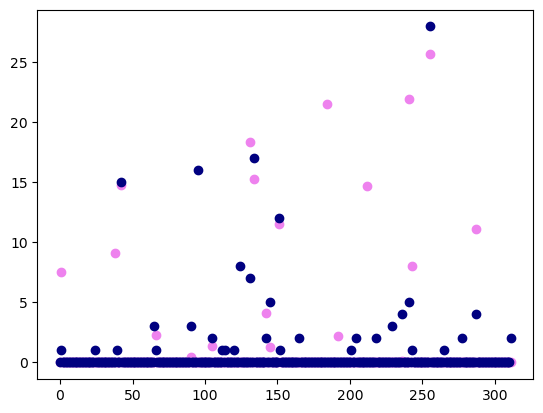

<Figure size 20x20 with 0 Axes>

In [56]:
fig = plt.scatter([i for i in range(312)], model.predict(np.array(X_ref_test)), color = 'violet')
fig = plt.scatter([i for i in range(312)], y_test['suicide'], color = 'navy')
plt.figure(figsize=(0.2,0.2))

## Regressions from Dissertation

## ZINB as predictive model

In [57]:
# read in dataset as a dataframe
df10 = pd.read_csv("BAAD_DataCompMar.2023.csv")

In [58]:
df10 = df10[['suicide', 'age', 'iideol', 'milpercap', 'ethn', 'size', 'terrcntrl', 'ssponsor', 'socialserv', 'lngroupbd', 'ngroups', 'vdem',
       'lnpop', 'lngdppc', 'torg']].dropna()

In [59]:
X_zinb=df10[['age', 'iideol', 'milpercap', 'ethn', 'size', 'terrcntrl', 'ssponsor', 'socialserv', 'lngroupbd', 'ngroups', 'vdem',
       'lnpop', 'lngdppc', 'torg']]
y_zinb= df10[['suicide']]

In [60]:
X_train_zinb, X_test_zinb, y_train_zinb, y_test_zinb = train_test_split(X_zinb, y_zinb, random_state=42)

In [174]:
zinb_model_pred = zinb(y_train_zinb, exog=X_train_zinb.loc[:, X_train_zinb.columns != 'torg'], exog_infl=X_train_zinb.loc[:, X_train_zinb.columns != 'torg'], p=0, inflation='logit', missing='drop')

In [178]:
# group size is scaled to continuous
fitted = zinb_model_pred.fit(method = 'ncg', maxiter=5000)
fitted.summary()

Optimization terminated successfully.
         Current function value: 0.440556
         Iterations: 57
         Function evaluations: 91
         Gradient evaluations: 91
         Hessian evaluations: 57


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                           suicide   No. Observations:                  920
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                      907
Method:                                      MLE   Df Model:                           12
Date:                           Thu, 25 Jul 2024   Pseudo R-squ.:                  0.2809
Time:                                   15:29:10   Log-Likelihood:                -405.31
converged:                                  True   LL-Null:                       -563.65
Covariance Type:                       nonrobust   LLR p-value:                 1.471e-60
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
inflate_age           -0.0599      0.047     -1.279      0.201      -0.152       0.032
inflate_iideol       -10.2460      2.673     -3.833      0.000     -15.485      -5.007
inflate_milpercap     -0.6260      0.212     -2.949      0.003      -1.042      -0.210
inflate_ethn          -5.1375      1.975     -2.601      0.009      -9.009      -1.266
inflate_size          -0.2494      1.079     -0.231      0.817      -2.364       1.865
inflate_terrcntrl     -3.2209      1.588     -2.028      0.043      -6.333      -0.109
inflate_ssponsor      14.1666      4.006      3.537      0.000       6.315      22.018
inflate_socialserv    -2.3974      1.300     -1.844      0.065      -4.945       0.151
inflate_lngroupbd     -0.1825      0.186     -0.981      0.327      -0.547       0.182
inflate_ngroups       -0.7540      0.316     -2.385      0.017      -1.374      -0.134
inflate_vdem          -7.3489      4.630     -1.587      0.112     -16.423       1.725
inflate_lnpop          1.4183      0.545      2.604      0.009       0.351       2.486
inflate_lngdppc       -0.8532      0.872     -0.979      0.328      -2.562       0.855
age                   -0.0122      0.009     -1.358      0.175      -0.030       0.005
iideol                 0.5083      0.221      2.305      0.021       0.076       0.941
milpercap              0.1087      0.030      3.613      0.000       0.050       0.168
ethn                  -0.2730      0.241     -1.132      0.258      -0.746       0.200
size                   0.0945      0.117      0.810      0.418      -0.134       0.323
terrcntrl             -0.2800      0.194     -1.440      0.150      -0.661       0.101
ssponsor               0.6098      0.266      2.290      0.022       0.088       1.132
socialserv            -0.3395      0.212     -1.605      0.109      -0.754       0.075
lngroupbd              0.3148      0.036      8.847      0.000       0.245       0.385
ngroups               -0.2013      0.043     -4.685      0.000      -0.285      -0.117
vdem                   2.1990      0.657      3.347      0.001       0.911       3.487
lnpop                  0.2537      0.075      3.402      0.001       0.108       0.400
lngdppc               -0.7080      0.194     -3.646      0.000      -1.089      -0.327
alpha                 38.0934     10.407      3.660      0.000      17.697      58.490
======================================================================================
"""

In [173]:
predictions_zinb = fitted.predict(exog=X_test_zinb.loc[:, X_test_zinb.columns != 'torg'], exog_infl=X_test_zinb.loc[:, X_test_zinb.columns != 'torg'])

In [64]:
# Evaluate the model's performance
print('R_squared: ',r2_score(y_test_zinb,predictions_zinb))
mse = mean_squared_error(y_test_zinb, predictions_zinb)
print("Root Mean Squared Error:", np.sqrt(mse))

R_squared:  0.3768653664090055
Root Mean Squared Error: 3.219948036805758


In [65]:
y_test_zinb["suicide_pred"] = predictions_zinb
print(y_test_zinb.head(30))
# y_test_zinb.to_csv("test.csv")

      suicide  suicide_pred
1176        0      1.417094
314         0      0.117072
1217        0      0.452206
315         0      0.099679
109        16      7.122975
744         0      0.060066
682         0      2.024043
142         0      0.172538
685         0      1.082003
477         0      0.109125
824         0      0.008481
1321        0      0.034686
1330        0      0.017265
854         0      0.181219
125         2      0.000000
390         0      0.009018
1052        0      0.014161
328         0      0.100986
187         0      0.140498
86          0      0.019332
817         0      0.013721
1236        0      0.066686
43          0      0.000000
692         0      0.071075
1249        0      0.015167
1035        0      0.174085
1353        0      0.015131
1011        0      0.009257
49          0      0.000000
1385        0      0.051096


## Predictive ZINB (Suicide Counts)

#### R_squared:  0.38
#### Root Mean Squared Error: 3.22